chi gan wo conditional generation

In [1]:
%matplotlib notebook
from sklearn import datasets, model_selection
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.legend_handler import HandlerLine2D
from utils import *

<IPython.core.display.Javascript object>


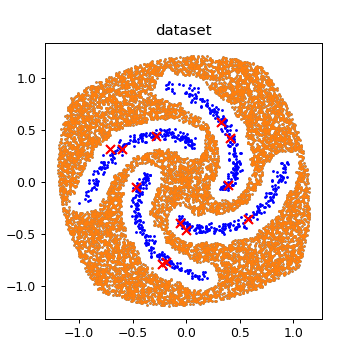

In [2]:
################Choose dataset #################
X,y = spiral(200)
# X,y = datasets.make_moons(n_samples=1000,noise=0.01)
# X = np.concatenate([np.random.multivariate_normal([-1.5,0],np.eye(2)/10,1000),np.random.multivariate_normal([+1.5,0],np.eye(2)/10,1000)])
# y = np.concatenate([np.ones(1000),np.zeros(1000)])
nb_labels = 3
################################################
ids = np.random.permutation(y.shape[0])
X=X[ids]
y=y[ids]
txs=[]
tys=[]
for j in range(int(np.max(y))+1):
    txs.append(X[y==j][:nb_labels])
    tys.append(y[y==j][:nb_labels])
X_lab = np.concatenate(txs,axis=0)
y_lab = np.concatenate(tys,axis=0)
f,ax = plt.subplots()
f.set_size_inches(4,4)

scatter_dataset(ax,X,np.zeros_like(y),s=1,c='b')
scatter_dataset(ax,X_lab,y_lab,s=50,marker='x',c='r')
ax.set_title('dataset')
# return X,y, X_lab, Y_lab
ex = gen_examples(10000,X)
scatter_dataset(ax,ex,np.zeros(ex.shape[0]),s=1)

In [11]:
X.shape

(800, 2)

In [3]:
def plot_gan(f,ax,deter=False):
    scale = 1.5
    xmin = -scale
    xmax = scale
    ymin = -scale
    ymax = scale
    xx, yy = make_meshgrid(xmin,xmax,ymin,ymax, h=0.05)
    ax[0].clear()
#     X_gen = ssgan.generate_random_samples(100)
    plot_contours(ax[0], ssgan.predict_fake, xx,yy,cmap=plt.cm.coolwarm, alpha=0.6)
    
    scatter_dataset(ax[0],X,np.zeros_like(y),s=0.5,c=(0.1,0.1,0.1))
    scatter_dataset(ax[0],X_lab,y_lab,s=5,marker='x')
    ax[0].set_title('classification')
    ax[0].set_xlim(xmin,xmax)
    ax[0].set_ylim(ymin,ymax)
    
    ax[1].clear()
    if deter:
        X_gen=gen_examples(200, X)
    else:
        X_gen = ssgan.generate_random_samples(200)
    plot_contours(ax[1], ssgan.discriminate, xx,yy,cmap=plt.cm.coolwarm, alpha=0.6)
    scatter_dataset(ax[1],X,np.zeros_like(y),s=1,c='b')
    ax[1].scatter(X_gen[:,0],X_gen[:,1],c='r',s=1)
    ax[1].set_title('real/fake discrimination')
    ax[1].set_xlim(xmin,xmax)
    ax[1].set_ylim(ymin,ymax)
    
    ax[2].clear()
    pred,acc = ssgan.predict(X,y,acc=True)
    scatter_dataset(ax[2],X,pred,s=1)
    ax[2].set_title('classification acc : %0.2f'%(acc))
    ax[2].set_xlim(xmin,xmax)
    ax[2].set_ylim(ymin,ymax)
    
    f.canvas.draw()

In [9]:
class Model ():
    
    def __init__(self, sess, batch_size = 100, x_dim=2, nb_class = 2, lr_d = 0.01, lr_g = 0.01,
                 z_dim = 2, print_frequency=199, nb_epoch = 100,verbose=True, deterministic_gen=True,
                bin_weight=0,fm_weight=1):
        self.sess = sess
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.nb_class = nb_class
        self.nb_epoch = nb_epoch
        self.batch_size = batch_size
        self.verbose = verbose
        self.print_frequency = print_frequency
        self.lr_d = lr_d
        self.lr_g = lr_g
        self.deter_g = deterministic_gen
        self.bin_weight = bin_weight
        self.fm_weight = fm_weight
        
        self.build_model()

    def generator(self, z, reuse=False):
        with tf.variable_scope("generator") as scope:
            if reuse:
                scope.reuse_variables()
            regularizer = tf.contrib.layers.l2_regularizer(scale=0.2)    

            h = tf.layers.dense(z,20, activation=tf.nn.relu,kernel_regularizer=regularizer)
            h = tf.layers.dense(z,20, activation=tf.nn.relu,kernel_regularizer=regularizer)
            h = tf.layers.dense(h,self.x_dim)
            return h

    def discriminator(self, inp, reuse, training_pl):
        with tf.variable_scope("discriminator") as scope:
            if reuse:
                scope.reuse_variables()
            regularizer = tf.contrib.layers.l2_regularizer(scale=0.001) 
            regularizer_strong = tf.contrib.layers.l1_regularizer(scale=0.8) 
            h = tf.layers.dense(inp,64, activation=tf.nn.relu,kernel_regularizer=regularizer)
#             h = tf.layers.dropout(h,0.5,training=training_pl)
            h = tf.layers.dense(h,64, activation=tf.nn.relu, kernel_regularizer=regularizer)
#             h = tf.layers.dropout(h,0.5,training=training_pl)
#             h = tf.layers.dense(h,4, activation=tf.nn.relu, kernel_regularizer=regularizer)
#             h = tf.layers.dropout(h,0.5,training=training_pl)
            layer = h
#             h = tf.layers.dense(h,4, activation=tf.nn.relu, kernel_regularizer=regularizer)

            dis = tf.layers.dense(h,1,kernel_regularizer=regularizer)
            with tf.variable_scope('classifier'):
#                 h = tf.layers.dropout(h,0.5,training=training_pl
#                 seed = tf.concat([h, dis],axis=1)
                class_logits = tf.layers.dense(h,self.nb_class,kernel_regularizer=regularizer_strong)           
            return class_logits, layer, dis

    def build_model(self):
        self.lab = tf.placeholder(tf.float32,[None,self.x_dim], name='input_lbl_data')
        self.unl = tf.placeholder(tf.float32,[None,self.x_dim], name='input_unl_data')
        self.z = tf.placeholder(tf.float32, [None,self.z_dim],name='z_seed')
        self.lbl = tf.placeholder(tf.int64, [None],name='labels')
        self.training_pl = tf.placeholder(tf.bool, [], name='is_training_pl')
        
        if self.deter_g:
            self.gen = tf.placeholder(tf.float32,[None,self.x_dim], name='complementary_gan')
        else:
            self.gen = self.generator(self.z,reuse=False)
        self.l_lab, _, self.dis_lab = self.discriminator(self.lab, False, self.training_pl)
        self.l_unl, self.layer_r,self.dis_unl = self.discriminator(self.unl, True, self.training_pl)
        self.l_fake, self.layer_f,self.dis_fake = self.discriminator(self.gen,True, self.training_pl)
        
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits
        sigmoid = tf.nn.sigmoid_cross_entropy_with_logits
        self.d_loss = 0.5*tf.reduce_mean(sigmoid(logits=self.dis_unl,labels=tf.ones_like(self.dis_unl)))+\
                        0.5*tf.reduce_mean(sigmoid(logits=self.dis_fake,labels=tf.zeros_like(self.dis_fake)))
        self.c_loss = tf.reduce_mean(xentropy(logits=self.l_lab,labels=self.lbl)) 
        #loss generator  
        m1=tf.reduce_mean(self.layer_r, axis=0)
        m2=tf.reduce_mean(self.layer_f, axis=0)
        self.fm_loss = tf.reduce_mean(tf.square(m1-m2))
        self.bin_loss = tf.reduce_mean(sigmoid(logits=self.dis_fake,labels=tf.ones_like(self.dis_fake)))
        self.g_loss = self.bin_weight * self.bin_loss + self.fm_weight * self.fm_loss
        
#         dd = tf.gradients(self.l_fake, self.z)
        dd = tf.gradients(self.layer_f, self.z)
        self.ddx = 10 * (tf.norm(dd)-1)**2
        print(dd)
#         self.g_loss += self.ddx
        self.c_loss += self.ddx
        
        # penalisation ent discriminator for classisier
#         self.ent_pen = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.dis_fake,logits=self.dis_fake)) 
        self.ent_pen = tf.reduce_mean(sigmoid(logits=self.dis_unl,labels=tf.ones_like(self.dis_unl)))                             
#         self.c_loss += self.ent_pen
#         self.c_loss = self.c_loss * (1+self.ent_pen)
        self.prediction_fake = tf.cast(tf.argmax(self.l_lab,1),tf.int32)
        self.prediction = tf.cast(tf.argmax(self.l_lab,1),tf.int32)                                 

        self.correct_prediction = tf.equal(tf.argmax(self.l_lab, 1), self.lbl)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        self.dis = 1-tf.cast(tf.greater(self.dis_lab,0.0),tf.float32)
    
        t_vars = tf.trainable_variables()
        self.d_vars = [var for var in t_vars if 'discriminator' in var.name]
        self.g_vars = [var for var in t_vars if 'generator' in var.name]  
        self.c_vars = [var for var in t_vars if 'classifier' in var.name] 
        self.d_optim = tf.train.AdamOptimizer(self.lr_d).minimize(loss=self.d_loss, var_list=self.d_vars)
        
        if not self.deter_g:
            self.g_optim = tf.train.AdamOptimizer(self.lr_g).minimize(loss=self.fm_loss, var_list=self.g_vars)
        self.c_optim = tf.train.AdamOptimizer(self.lr_d).minimize(loss=self.c_loss, var_list=self.c_vars+self.d_vars)

        

    def train(self,f,ax, X_unl,X_lab, y, X_test,y_test):
        self.trainx_unl = X_unl
        self.trainx_unl2 = X_unl.copy()
        self.trainy = y
        self.trainx = X_lab
        self.testx = X_test
        self.testy = y_test
        
        self.nb_examples_unl = self.trainx_unl.shape[0]
        self.nb_examples_lab = self.trainx.shape[0]
        self.nb_step = self.nb_examples_unl//self.batch_size
        
        tx = []
        ty = []
        for t in range(self.nb_examples_unl//self.nb_examples_lab):
            inds = np.random.permutation(self.nb_examples_lab)
            tx.append(self.trainx[inds])
            ty.append(self.trainy[inds])
        self.trainx = np.concatenate(tx, axis=0)
        self.trainy = np.concatenate(ty, axis=0)

        self.sess.run(tf.global_variables_initializer())
        for epoch in range(self.nb_epoch):            
            ids = np.random.permutation(self.trainx.shape[0])
            self.trainx = self.trainx[ids]
            self.trainy = self.trainy[ids]
            self.trainx_unl = self.trainx_unl[np.random.permutation(self.trainx_unl.shape[0])]
            self.trainx_unl2 = self.trainx_unl2[np.random.permutation(self.trainx_unl2.shape[0])]
            lossgrad = 0
            ll_d = 0
            ll_g = 0 
            ll_c = 0
            for step in range(self.nb_step):
                ran_from = step * self.batch_size
                ran_to = (step+1) * self.batch_size
                if self.deter_g:
                    feed_dict={self.unl:self.trainx_unl[ran_from:ran_to],
                           self.gen:gen_examples(self.batch_size, self.trainx_unl),
                           self.training_pl:True}
                else:
                    feed_dict={self.unl:self.trainx_unl[ran_from:ran_to],
                           self.z:np.random.randn(self.batch_size,self.z_dim),
                            self.training_pl:True}
                _, ll = self.sess.run([self.d_optim, self.d_loss],feed_dict=feed_dict)
                ll_d += ll
                feed_dict={self.lab:self.trainx[ran_from:ran_to],
                            self.lbl:self.trainy[ran_from:ran_to],
                           self.unl:self.trainx_unl[ran_from:ran_to],
                           self.gen:gen_examples(self.batch_size, self.trainx_unl),
                           self.z:np.random.randn(self.batch_size,self.z_dim),
                          self.training_pl:True}
                _, ll,lld = self.sess.run([self.c_optim, self.c_loss,self.ddx ],feed_dict=feed_dict)
                ll_c += ll
                lossgrad=lld
                if not self.deter_g:
                    _, ll = self.sess.run([self.g_optim, self.fm_loss],feed_dict={self.unl:self.trainx_unl2[ran_from:ran_to],
                                                                             self.z:np.random.randn(self.batch_size,self.z_dim),
                                                                                 self.training_pl:True})
                    ll_g += ll
            ll_d /= self.nb_step
            ll_g /= self.nb_step 
            ll_c /= self.nb_step
            lossgrad /= self.nb_step
            if (epoch % self.print_frequency == 0):
                train_acc = self.sess.run(self.accuracy,feed_dict={self.lab:X_lab,
                                                                   self.lbl:y,
                                                                  self.training_pl:False})
                test_acc = self.sess.run(self.accuracy,feed_dict={self.lab:X_test, 
                                                                  self.lbl:y_test,
                                                                 self.training_pl:False})

#                 print('epoch %d | loss d = %0.4f | loss g = %0.4f | loss c = %0.4f | train acc = %0.2f | test acc = %0.2f'
#                                   %(epoch, ll_d, ll_g,ll_c, train_acc*100, test_acc*100))
                print('epoch %d , grad loss %0.6f' %(epoch,lossgrad))
                plot_gan(f,ax,self.deter_g)

    def predict(self, X_test, y_test=False,acc=False):
        if acc == False:  
            return self.sess.run(self.prediction ,feed_dict={self.lab:X_test})

        return self.sess.run([self.prediction, self.accuracy],feed_dict={self.lab:X_test,
                                                                         self.lbl:y_test,
                                                                        self.training_pl:False})
        
    
    def predict_fake(self, X_test, y_test=False,acc=False):
        if acc == False:    
            return self.sess.run(self.prediction_fake ,feed_dict={self.lab:X_test,self.training_pl:False})
        
        return self.sess.run([self.prediction, self.accuracy],feed_dict={self.lab:X_test,
                                                                         self.lbl:y_test,
                                                                        self.training_pl:False})
                                         
    
    def discriminate(self, X_test, y_test=None):
        if y_test == None:     
            pred = self.sess.run(self.dis ,feed_dict={self.lab:X_test,self.training_pl:False})
            return pred
                                 

    def generate_random_samples(self, nb_samples):
        return self.sess.run(self.gen,feed_dict={self.z:np.random.randn(nb_samples,self.z_dim),self.training_pl:False})                      

[<tf.Tensor 'gradients/generator/dense_2/MatMul_grad/MatMul:0' shape=(?, 2) dtype=float32>]


<IPython.core.display.Javascript object>


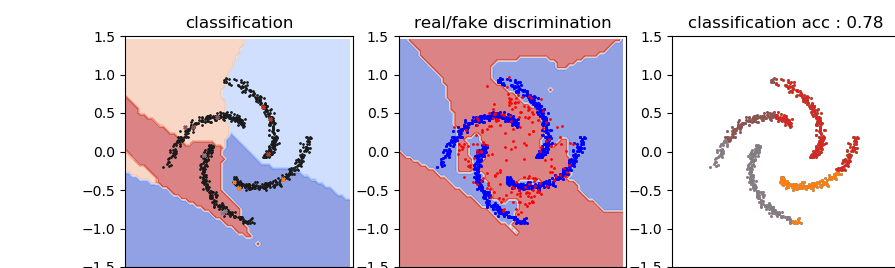

epoch 0 , grad loss 12.138225
epoch 1 , grad loss 4.679018
epoch 2 , grad loss 2.383755
epoch 3 , grad loss 2.510422
epoch 4 , grad loss 3.018949
epoch 5 , grad loss 2.971661
epoch 6 , grad loss 5.610998
epoch 7 , grad loss 4.376190
epoch 8 , grad loss 8.418451
epoch 9 , grad loss 9.248415
epoch 10 , grad loss 16.921528
epoch 11 , grad loss 16.548615
epoch 12 , grad loss 14.913856
epoch 13 , grad loss 15.774145
epoch 14 , grad loss 16.640505
epoch 15 , grad loss 13.141769
epoch 16 , grad loss 12.503657
epoch 17 , grad loss 9.522036
epoch 18 , grad loss 13.247818
epoch 19 , grad loss 11.707289
epoch 20 , grad loss 12.838239
epoch 21 , grad loss 5.803523
epoch 22 , grad loss 6.068370
epoch 23 , grad loss 5.540607
epoch 24 , grad loss 4.612200
epoch 25 , grad loss 3.786910
epoch 26 , grad loss 4.098155
epoch 27 , grad loss 2.735962
epoch 28 , grad loss 2.692622
epoch 29 , grad loss 4.705830
epoch 30 , grad loss 2.857647
epoch 31 , grad loss 3.685771
epoch 32 , grad loss 2.391128
epoch 33 

epoch 268 , grad loss 2.284064
epoch 269 , grad loss 1.427254
epoch 270 , grad loss 9.935113
epoch 271 , grad loss 5.481384
epoch 272 , grad loss 3.816352
epoch 273 , grad loss 6.153187
epoch 274 , grad loss 1.330029
epoch 275 , grad loss 2.198651
epoch 276 , grad loss 0.968104
epoch 277 , grad loss 1.336826
epoch 278 , grad loss 8.973518
epoch 279 , grad loss 1.007545
epoch 280 , grad loss 1.950469
epoch 281 , grad loss 4.050253
epoch 282 , grad loss 5.275291
epoch 283 , grad loss 2.470815
epoch 284 , grad loss 0.989189
epoch 285 , grad loss 2.583938
epoch 286 , grad loss 1.091664
epoch 287 , grad loss 2.002647
epoch 288 , grad loss 2.049787
epoch 289 , grad loss 3.375361
epoch 290 , grad loss 4.149183
epoch 291 , grad loss 2.079866
epoch 292 , grad loss 1.356113
epoch 293 , grad loss 1.345984
epoch 294 , grad loss 2.815387
epoch 295 , grad loss 0.736822
epoch 296 , grad loss 1.113169
epoch 297 , grad loss 0.898982
epoch 298 , grad loss 1.439490
epoch 299 , grad loss 2.503561
epoch 30

epoch 532 , grad loss 1.905320
epoch 533 , grad loss 0.873755
epoch 534 , grad loss 1.238231
epoch 535 , grad loss 0.786504
epoch 536 , grad loss 0.676995
epoch 537 , grad loss 1.837586
epoch 538 , grad loss 0.835563
epoch 539 , grad loss 5.277094
epoch 540 , grad loss 1.314103
epoch 541 , grad loss 0.777381
epoch 542 , grad loss 2.199077
epoch 543 , grad loss 1.334571
epoch 544 , grad loss 120.336563
epoch 545 , grad loss 1.514396
epoch 546 , grad loss 0.462293
epoch 547 , grad loss 2.652837
epoch 548 , grad loss 1.761164
epoch 549 , grad loss 1.468310
epoch 550 , grad loss 0.692328
epoch 551 , grad loss 0.317202
epoch 552 , grad loss 2.631880
epoch 553 , grad loss 1.060614
epoch 554 , grad loss 1.352378
epoch 555 , grad loss 1.094613
epoch 556 , grad loss 0.787850
epoch 557 , grad loss 2.271266
epoch 558 , grad loss 0.737218
epoch 559 , grad loss 1.842703
epoch 560 , grad loss 0.462042
epoch 561 , grad loss 1.666861
epoch 562 , grad loss 0.997933
epoch 563 , grad loss 2.285548
epoch 

epoch 796 , grad loss 2.996622
epoch 797 , grad loss 0.820187
epoch 798 , grad loss 0.925124
epoch 799 , grad loss 1.734520
epoch 800 , grad loss 4.752052
epoch 801 , grad loss 5.513270
epoch 802 , grad loss 2.257732
epoch 803 , grad loss 1.629628
epoch 804 , grad loss 0.630502
epoch 805 , grad loss 0.178845
epoch 806 , grad loss 0.805376
epoch 807 , grad loss 0.705035
epoch 808 , grad loss 1.183589
epoch 809 , grad loss 1.013621
epoch 810 , grad loss 3.012194
epoch 811 , grad loss 2.878764
epoch 812 , grad loss 1.852217
epoch 813 , grad loss 6.262640
epoch 814 , grad loss 7.744625
epoch 815 , grad loss 1.244307
epoch 816 , grad loss 2.946874
epoch 817 , grad loss 1.636477
epoch 818 , grad loss 5.002370
epoch 819 , grad loss 0.661587
epoch 820 , grad loss 0.723348
epoch 821 , grad loss 3.230377
epoch 822 , grad loss 2.400303
epoch 823 , grad loss 1.352130
epoch 824 , grad loss 0.272575
epoch 825 , grad loss 1.208709
epoch 826 , grad loss 0.604977
epoch 827 , grad loss 6.788347
epoch 82

epoch 1058 , grad loss 1.115694
epoch 1059 , grad loss 0.307058
epoch 1060 , grad loss 8.191046
epoch 1061 , grad loss 2.219476
epoch 1062 , grad loss 0.478959
epoch 1063 , grad loss 0.535459
epoch 1064 , grad loss 0.437212
epoch 1065 , grad loss 0.393072
epoch 1066 , grad loss 0.131428
epoch 1067 , grad loss 0.681507
epoch 1068 , grad loss 0.746751
epoch 1069 , grad loss 0.450011
epoch 1070 , grad loss 0.032623
epoch 1071 , grad loss 0.214492
epoch 1072 , grad loss 0.244398
epoch 1073 , grad loss 0.310243
epoch 1074 , grad loss 0.743135
epoch 1075 , grad loss 0.490875
epoch 1076 , grad loss 0.247327
epoch 1077 , grad loss 0.251705
epoch 1078 , grad loss 0.168020
epoch 1079 , grad loss 0.023642
epoch 1080 , grad loss 1.517829
epoch 1081 , grad loss 17.900528
epoch 1082 , grad loss 0.750035
epoch 1083 , grad loss 0.264907
epoch 1084 , grad loss 0.545953
epoch 1085 , grad loss 0.075180
epoch 1086 , grad loss 0.656483
epoch 1087 , grad loss 0.283523
epoch 1088 , grad loss 1.112416
epoch 1

epoch 1313 , grad loss 39.883713
epoch 1314 , grad loss 2.661376
epoch 1315 , grad loss 125.323021
epoch 1316 , grad loss 2.220733
epoch 1317 , grad loss 4.106668
epoch 1318 , grad loss 1.647828
epoch 1319 , grad loss 101.471527
epoch 1320 , grad loss 9.658865
epoch 1321 , grad loss 2.292624
epoch 1322 , grad loss 7.146857
epoch 1323 , grad loss 5.797759
epoch 1324 , grad loss 1.508082
epoch 1325 , grad loss 1.898056
epoch 1326 , grad loss 1.073586
epoch 1327 , grad loss 1.919008
epoch 1328 , grad loss 1.861513
epoch 1329 , grad loss 146.296295
epoch 1330 , grad loss 1.868484
epoch 1331 , grad loss 1.865801
epoch 1332 , grad loss 0.804963
epoch 1333 , grad loss 0.464266
epoch 1334 , grad loss 0.375940
epoch 1335 , grad loss 6.797506
epoch 1336 , grad loss 20.550591
epoch 1337 , grad loss 85.127045
epoch 1338 , grad loss 273.173218
epoch 1339 , grad loss 1.570500
epoch 1340 , grad loss 1.868172
epoch 1341 , grad loss 2.444876
epoch 1342 , grad loss 0.887683
epoch 1343 , grad loss 0.8759

AttributeError: 'Figure' object has no attribute 'close'

In [10]:
tf.reset_default_graph()
# sess = tf.InteractiveSession()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
ssgan = Model(sess, nb_epoch=1500, lr_g=0.0003, lr_d=0.001, print_frequency=1,
              nb_class=4,batch_size=100, deterministic_gen=False,bin_weight=0, fm_weight=1)

f, ax = plt.subplots(1,3, sharex=True)
f.set_size_inches(10,3)
f.subplots_adjust(hspace=0.5)
plt.ion()
f.show()
f.canvas.draw()

ssgan.train(f,ax,X,X_lab,y_lab,X,y)
f.close()